### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
root = "drive/MyDrive/DEP"

### Imports

In [ ]:
import os
import cv2
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split
from torch.utils.data import Dataset , DataLoader, TensorDataset
import torch.nn.functional as func
import torch.nn.functional as F
from torch import nn

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

from pdb import set_trace as stx
import numbers

!pip install einops
from einops import rearrange


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Transformer Block

In [ ]:
## Layer Norm
def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x, 'b (h w) c -> b c h w',h=h,w=w)

class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma+1e-5) * self.weight

class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma+1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type =='BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)

In [ ]:
## Gated-Dconv Feed-Forward Network (GDFN)
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_expansion_factor, bias):
        super(FeedForward, self).__init__()

        hidden_features = int(dim*ffn_expansion_factor)

        self.project_in = nn.Conv2d(dim, hidden_features*2, kernel_size=1, bias=bias)

        self.dwconv = nn.Conv2d(hidden_features*2, hidden_features*2, kernel_size=3, stride=1, padding=1, groups=hidden_features*2, bias=bias)

        self.project_out = nn.Conv2d(hidden_features, dim, kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.project_in(x)
        x1, x2 = self.dwconv(x).chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x

In [ ]:
## Multi-DConv Head Transposed Self-Attention (MDTA)
class Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim*3, kernel_size=1, bias=bias)
        self.qkv_dwconv = nn.Conv2d(dim*3, dim*3, kernel_size=3, stride=1, padding=1, groups=dim*3, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)



    def forward(self, x):
        b,c,h,w = x.shape

        qkv = self.qkv_dwconv(self.qkv(x))
        q,k,v = qkv.chunk(3, dim=1)

        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = (attn @ v)

        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)

        out = self.project_out(out)
        return out

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_expansion_factor, bias=False, LayerNorm_type='BiasFree'):
        super(TransformerBlock, self).__init__()

        self.norm1 = LayerNorm(dim, LayerNorm_type)
        self.attn = Attention(dim, num_heads, bias)
        self.norm2 = LayerNorm(dim, LayerNorm_type)
        self.ffn = FeedForward(dim, ffn_expansion_factor, bias)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))

        return x

### Sub-Blocks

In [ ]:
class B_Block(nn.Module):
    def __init__(self, ins, outs):
        super().__init__()
        self.C1 = nn.Sequential(nn.Conv2d(in_channels=ins, out_channels=ins, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(ins),
                                nn.ReLU()
                                )
        self.C2 = nn.Sequential(nn.Conv2d(in_channels=ins, out_channels=ins, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(ins),
                                nn.ReLU()
                                )
        self.C3 = nn.Sequential(nn.Conv2d(in_channels=ins, out_channels=ins, kernel_size=3, stride=2, padding=1),
                                nn.BatchNorm2d(outs),
                                nn.ReLU()
                                )
        self.tr = TransformerBlock(32, 8, 2.66)

    def forward(self, x):
        out1 = self.C1(x)
        out2 = self.C2(out1)
        out2 = out2 + x
        out3 = self.C3(out2)
        outf = self.tr(out3)
        return outf

In [ ]:
class Residual(nn.Module):
    def __init__(self, ins, outs):
        super().__init__()
        self.C1 = nn.Sequential(nn.Conv2d(in_channels=ins, out_channels=ins, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(ins),
                                nn.ReLU()
                                )
        self.C2 = nn.Sequential(nn.Conv2d(in_channels=ins, out_channels=ins, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(ins),
                                nn.ReLU()
                                )

    def forward(self, x):
        out1 = self.C1(x)
        out2 = self.C2(out1)
        outf = out2 + x
        return outf

In [ ]:
class D_Block(nn.Module):
    def __init__(self, ins, outs):
        super().__init__()
        self.C1 = nn.Sequential(nn.ConvTranspose2d(in_channels=ins, out_channels=ins, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(ins),
                                nn.ReLU()
                                )
        self.C2 = nn.Sequential(nn.ConvTranspose2d(in_channels=ins, out_channels=ins, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(ins),
                                nn.ReLU()
                                )
        self.C3 = nn.Sequential(nn.ConvTranspose2d(in_channels=ins, out_channels=ins, kernel_size=(3, 4), stride=(1, 2), padding=1),
                                nn.BatchNorm2d(outs),
                                nn.ReLU()
                                )
        self.tr = TransformerBlock(32, 8, 2.66)

    def forward(self, x):
        out1 = self.C1(x)
        out2 = self.C2(out1)
        out2 = out2 + x
        out3 = self.C3(out2)
        outf = self.tr(out3)
        return outf

In [ ]:
# Assuming you have a batch of images
batch_size = 20
channels = 32
height_in = 36
width_in = 18

input_images = torch.rand((batch_size, channels, height_in, width_in))
print(input_images.size())

conv_transpose = nn.ConvTranspose2d(in_channels=channels, out_channels=channels, kernel_size=(3, 4), stride=(1, 2), padding=1)

output_images = conv_transpose(input_images)

print(output_images.size())

torch.Size([20, 32, 36, 18])
torch.Size([20, 32, 36, 36])


### Final Model

In [ ]:
def concatenate(in1, in2, dim=2):
    return torch.cat([in1, in2], dim=dim)

In [ ]:
class FinalModel(nn.Module):
    def __init__(self):
        super(FinalModel, self).__init__()

        self.cin1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(32),
                                nn.ReLU()
                                )
        self.B11 = B_Block(32, 32)
        self.B21 = B_Block(32, 32)
        self.B31 = B_Block(32, 32)
        self.R11 = Residual(32, 32)
        self.R21 = Residual(32, 32)

        self.cin2 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(32),
                                nn.ReLU()
                                )
        self.B12 = B_Block(32, 32)
        self.B22 = B_Block(32, 32)
        self.B32 = B_Block(32, 32)
        self.R12 = Residual(32, 32)
        self.R22 = Residual(32, 32)

        self.D1 = D_Block(32, 32)
        self.D2 = D_Block(32, 32)
        self.D3 = D_Block(32, 32)
        self.cout = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1),
                                nn.BatchNorm2d(3),
                                nn.ReLU()
                                )


    def forward(self, x1, x2): # (bx3x72x72)
        in11 = self.cin1(x1)     # (bx32x72x72)
        in21 = self.B11(in11)    # (bx32x36x36)
        in31 = self.B21(in21)    # (bx32x18x18)
        in41 = self.B31(in31)    # (bx32x9x9)
        in51 = self.R11(in41)    # (bx32x9x9)
        in61 = self.R21(in51)    # (bx32x9x9)

        in12 = self.cin2(x2)     # (bx32x72x72)
        in22 = self.B12(in12)    # (bx32x36x36)
        in32 = self.B22(in22)    # (bx32x18x18)
        in42 = self.B32(in32)    # (bx32x9x9)
        in52 = self.R12(in42)    # (bx32x9x9)
        in62 = self.R22(in52)    # (bx32x9x9)

        addr = in61 + in62                  # (bx32x9x9)
        addb3 = in41 + in42                 # (bx32x9x9)
        con1 = concatenate(addr, addb3)     # (bx32x18x9)
        out1 = self.D1(con1)                # (bx32x18x18)

        addb2 = in31 + in32                 # (bx32x18x18)
        con2 = concatenate(out1, addb2)     # (bx32x36x18)
        out2 = self.D2(con2)                # (bx32x36x36)

        addb1 = in21 + in22                 # (bx32x36x36)
        con3 = concatenate(out2, addb1)     # (bx32x72x36)
        out3 = self.D3(con3)                # (bx32x72x72)

        outf = self.cout(out3)   # (bx3x72x72)

        return outf

In [ ]:
PatchModel = FinalModel()

### Old Training Dataset

In [ ]:
# Program To Read video and Extract Frames
def FrameCapture(path):
	vidObj = cv2.VideoCapture(path)
	success = 1
	frames = []
	# h, w, c = 1080, 1120, 3
	while success:
		success, image = vidObj.read()
		image = np.array(image)
		# if( image.shape == (h, w, c)) frames.append(image)
		frames.append(image)
	return frames

In [ ]:
data_folder = root+"/train_videos"
videos_list = [v for v in os.listdir(data_folder) if v.lower().endswith(('.mp4'))]
dataset = []
print(videos_list)

for video_name in videos_list:
    video_path = os.path.join(data_folder, video_name)

    frames = FrameCapture(video_path)
    print(video_path, len(frames))

    for frame in frames:
        dataset.append(frame)

# dataset = np.array(dataset)
print(len(dataset))
# print(dataset[0].shape)
print(type(dataset))


['all.mp4']


KeyboardInterrupt: 

In [ ]:
def get_arranged_frames(dataset):
    h, w, c = dataset[0].shape
    crop_width = int(w/2)

    arranged_dataset = []

    for i in range(len(dataset)):
        # print(i)
        if(i==0):
            img1 = dataset[i]
            img2 = dataset[i]
        else:
            img1 = dataset[i-1]
            img2 = dataset[i]

        if(img1.shape != (h, w, c) or img2.shape != (h, w, c)):
            continue

        # print(img1.shape)
        img1 = np.transpose(img1, (2, 1, 0))
        img1 = img1[:, 0:crop_width, :]

        img2 = np.transpose(img2, (2, 1, 0))
        img2, label2 = img2[:, 0:crop_width, :], img2[:, crop_width:w, :]
        # print(label2.shape)
        # print(img1.shape)

        # print(type(img1))
        img1 = img1.astype(np.float32)
        img2 = img2.astype(np.float32)
        label2 = label2.astype(np.float32)

        label2 = np.where(label2 <= 100, 0, label2)  # Set values less than 50 to 0
        label2 = np.where(label2 > 100, 1, label2)  # Set values greater than 150 to 1

        img1 = torch.tensor(img1)
        img2 = torch.tensor(img2)
        label2 = torch.tensor(label2)

        arranged_dataset.append((img1, img2, label2))
    return arranged_dataset

tensor_dataset = get_arranged_frames(dataset)
print(len(tensor_dataset))

### New Training Dataset

In [ ]:
# Program To Read video and Extract Frames
def FrameCapture(path):
	vidObj = cv2.VideoCapture(path)
	success = 1
	frames = []
	# h, w, c = 1080, 1120, 3
	while success:
		success, image = vidObj.read()
		image = np.array(image)
		# if( image.shape == (h, w, c)) frames.append(image)
		frames.append(image)
	return frames

In [ ]:
video1 = root+"/new_train_videos/patch1_video1.mp4"
video2 = root+"/new_train_videos/concatenated1.mp4"

dataset1 = FrameCapture(video1)
print(len(dataset1))

dataset2 = FrameCapture(video2)
print(len(dataset2))

video1 = root+"/new_train_videos/patch1_video2.mp4"
video2 = root+"/new_train_videos/concatenated2.mp4"

temp = FrameCapture(video1)
for frame in temp:
    dataset1.append(frame)
print(len(dataset1))

temp = FrameCapture(video2)
for frame in temp:
    dataset2.append(frame)
print(len(dataset2))

2360
2359
4592
4590


In [ ]:
def get_arranged_frames(dataset1, dataset2):
    h, w, c = dataset2[0].shape
    print(dataset1[0].shape)
    print(dataset2[0].shape)

    crop_width = int(w/2)

    arranged_dataset = []

    for i in range(len(dataset2)):
        # print(i)
        img1 = dataset1[i]
        img2 = dataset2[i]

        if(img1.shape != (h, int(w/2), c) or img2.shape != (h, w, c)):
            continue

        # print(img1.shape)
        # img1 = np.transpose(img1, (2, 1, 0))
        # img2 = np.transpose(img2, (2, 1, 0))
        # img2, label2 = img2[:, 0:crop_width, :], img2[:, crop_width:w, :]

        img1 = np.transpose(img1, (2, 0, 1))
        img2 = np.transpose(img2, (2, 0, 1))
        img2, label2 = img2[:, :, 0:crop_width], img2[:, :, crop_width:w]
        # print(label2.shape)
        # print(img1.shape)

        # print(type(img1))
        img1 = img1.astype(np.float32)
        img2 = img2.astype(np.float32)
        label2 = label2.astype(np.float32)

        label2 = np.where(label2 <= 100, 0, label2)  # Set values less than 50 to 0
        label2 = np.where(label2 > 100, 1, label2)  # Set values greater than 150 to 1

        img1 = torch.tensor(img1)
        img2 = torch.tensor(img2)
        label2 = torch.tensor(label2)
        # print(type(img1))

        arranged_dataset.append((img1, img2, label2))
    return arranged_dataset

tensor_dataset = get_arranged_frames(dataset1, dataset2)

(72, 72, 3)
(72, 144, 3)


### Dataset Preparation for Training

In [ ]:
# tensor_dataset = np.array(tensor_dataset)

print(len(tensor_dataset))
print(type(tensor_dataset))
print(len(tensor_dataset[0]))
print(type(tensor_dataset[0]))
print(len(tensor_dataset[0][0]))
print(type(tensor_dataset[0][0]))
# print(tensor_dataset.shape)
# print(tensor_dataset[0].shape)
print(tensor_dataset[0][0].shape, tensor_dataset[0][1].shape, tensor_dataset[0][2].shape)

4587
<class 'list'>
3
<class 'tuple'>
3
<class 'torch.Tensor'>
torch.Size([3, 72, 72]) torch.Size([3, 72, 72]) torch.Size([3, 72, 72])


In [ ]:
img1_list, img2_list, label_list = zip(*tensor_dataset)

# Convert the lists to PyTorch tensors
img1_tensor = torch.stack(img1_list)
img2_tensor = torch.stack(img2_list)
label_tensor = torch.stack(label_list)

# Create a TensorDataset
tensor_dataset = TensorDataset(img1_tensor, img2_tensor, label_tensor)

In [ ]:
val_size = int(0.2*(len(tensor_dataset)))
train_size = len(tensor_dataset) - val_size

train_ds, val_ds = random_split(tensor_dataset, [train_size, val_size])

print(len(train_ds))
print(type(train_ds))
print(len(val_ds))
print(type(val_ds))
print(type(val_ds[0]))
# print(val_ds[0].shape)
print(type(val_ds[0][0]), type(val_ds[0][1]), type(val_ds[0][2]))
print(val_ds[0][0].shape, val_ds[0][1].shape, val_ds[0][2].shape)

print(val_ds[0])

3670
<class 'torch.utils.data.dataset.Subset'>
917
<class 'torch.utils.data.dataset.Subset'>
<class 'tuple'>
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 72, 72]) torch.Size([3, 72, 72]) torch.Size([3, 72, 72])
(tensor([[[ 83.,  85.,  85.,  ...,  81.,  82.,  82.],
         [ 82.,  83.,  83.,  ...,  81.,  82.,  82.],
         [ 82.,  83.,  83.,  ...,  81.,  82.,  82.],
         ...,
         [ 83.,  83.,  83.,  ...,  85.,  85.,  85.],
         [ 81.,  81.,  81.,  ...,  85.,  85.,  85.],
         [ 81.,  81.,  81.,  ...,  85.,  85.,  85.]],

        [[117., 119., 119.,  ..., 116., 117., 117.],
         [116., 117., 117.,  ..., 116., 117., 117.],
         [116., 117., 117.,  ..., 116., 117., 117.],
         ...,
         [117., 117., 117.,  ..., 121., 120., 120.],
         [117., 117., 117.,  ..., 121., 120., 120.],
         [117., 117., 117.,  ..., 121., 120., 120.]],

        [[110., 112., 112.,  ..., 106., 107., 107.],
         [109., 110., 110., 

torch.Size([32, 3, 72, 72])


torch.Size([32, 3, 72, 72])
torch.Size([32, 3, 72, 72])


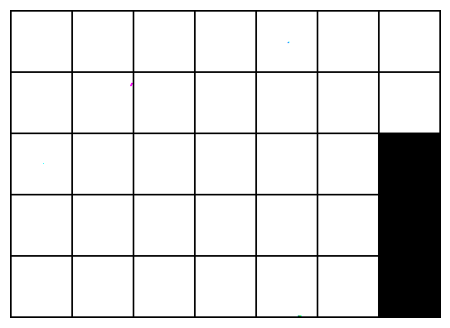

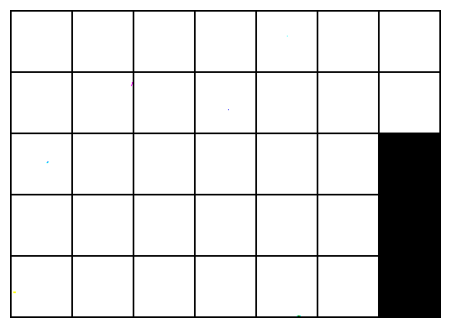

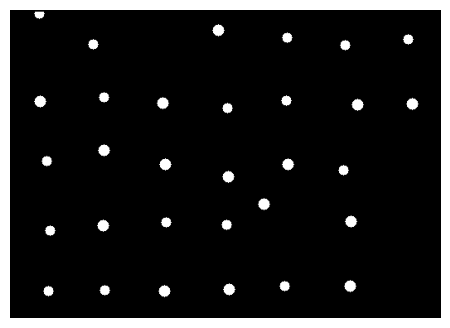

In [ ]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

for batch in train_dl:
    img1, img2, label2 = batch

    print(img1.shape)
    plt.figure(figsize=(8,4))
    plt.axis('off')
    plt.imshow(make_grid(img1, nrow=5).permute((2, 1, 0)))

    print(img2.shape)
    plt.figure(figsize=(8,4))
    plt.axis('off')
    plt.imshow(make_grid(img2, nrow=5).permute((2, 1, 0)))

    print(label2.shape)
    plt.figure(figsize=(8,4))
    plt.axis('off')
    plt.imshow(make_grid(label2, nrow=5).permute((2, 1, 0)))
    break

### Training PatchModel

In [ ]:
def accuracy(pred_masks, true_masks):
    pred_masks_binary = np.where(pred_masks.cpu().detach().numpy() > 0.5, 1, 0)

    # print(pred_masks_binary.shape)
    # print(true_masks.shape)

    correct_pixels = np.sum(pred_masks_binary == true_masks.cpu().numpy())
    total_pixels = np.prod(pred_masks.shape)

    acc = correct_pixels / total_pixels

    # print(correct_pixels, total_pixels, acc)
    return torch.tensor(acc)

In [ ]:
def dice_loss(pred, target):
    smooth = 1e-5
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() + smooth
    return 1 - (2 * intersection) / union

In [ ]:
def training_step(model, batch):
    input1, input2, target = batch
    out = model(input1, input2)

    sigmo = nn.Sigmoid()
    out = sigmo(out)
    # print(out.shape, target.shape)
    assert out.shape == target.shape, "Predictions and target labels must have the same shape"

    loss = dice_loss(out, target)
    # loss = func.binary_cross_entropy(out, target)
    return loss

def validation_step(model, batch):
    input1, input2, target = batch
    out = model(input1, input2)                     # Generate predictions

    sigmo = nn.Sigmoid()
    out = sigmo(out)
    assert out.shape == target.shape, "Predictions and target labels must have the same shape"
    # lossfxn = nn.BCELoss()
    # loss = lossfxn(out, target)
    loss = dice_loss(out, target)
    # loss = func.binary_cross_entropy(out, target)          # Calculate loss
    acc = accuracy(out, target)                     # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc':acc}

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
#Training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(epochs, model, train_loader, val_loader, lr, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    weight_decay = 0
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)

    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch)
            train_losses.append(loss)
            loss.backward()

            nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(epoch, result)
        history.append(result)

    return history

### **Loading the training, validation & test data, & model to the GPU**

In [ ]:
import torch
torch.cuda.is_available()

False

In [ ]:
def get_default_device():
  ''' Function to select the available device '''
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(device, data):
  ''' Function to move the tensor/data to the selected device '''
  if isinstance(data, (list, tuple)):
    return [to_device(device, x) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, DL, device):
    self.DL = DL
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for batch in self.DL:
      yield to_device(self.device, batch)

  def __len__(self):
    """Number of batches"""
    return len(self.DL)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
to_device(device, PatchModel)

FinalModel(
  (cin1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (B11): B_Block(
    (C1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (C2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (C3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (tr): TransformerBlock(
      (norm1): LayerNorm(
        (body): BiasFree_LayerNorm()
      )
      (attn): Attention(

In [ ]:
for img1b, img2b, label2b in train_dl:
  print(img1b.device, img2b.device, label2b.device)
  break
for img1b, img2b, label2b in val_dl:
  print(img1b.device, img2b.device, label2b.device)
  break

cuda:0 cuda:0 cuda:0
cuda:0 cuda:0 cuda:0


### Training the Model

In [ ]:
opt_func = torch.optim.Adam

In [ ]:
history = train(50, PatchModel, train_dl, val_dl, 0.001, opt_func)

Epoch [0], last_lr: 0.00005, train_loss: 0.9093, val_loss: 0.9120, val_acc: 0.9913
Epoch [1], last_lr: 0.00008, train_loss: 0.9093, val_loss: 0.9119, val_acc: 0.9911
Epoch [2], last_lr: 0.00013, train_loss: 0.9093, val_loss: 0.9120, val_acc: 0.9913
Epoch [3], last_lr: 0.00020, train_loss: 0.9093, val_loss: 0.9118, val_acc: 0.9906
Epoch [4], last_lr: 0.00028, train_loss: 0.9094, val_loss: 0.9120, val_acc: 0.9904
Epoch [5], last_lr: 0.00037, train_loss: 0.9094, val_loss: 0.9118, val_acc: 0.9898
Epoch [6], last_lr: 0.00047, train_loss: 0.9095, val_loss: 0.9118, val_acc: 0.9897
Epoch [7], last_lr: 0.00057, train_loss: 0.9096, val_loss: 0.9117, val_acc: 0.9895
Epoch [8], last_lr: 0.00067, train_loss: 0.9097, val_loss: 0.9124, val_acc: 0.9881
Epoch [9], last_lr: 0.00076, train_loss: 0.9099, val_loss: 0.9117, val_acc: 0.9794
Epoch [10], last_lr: 0.00084, train_loss: 0.9100, val_loss: 0.9124, val_acc: 0.9827
Epoch [11], last_lr: 0.00091, train_loss: 0.9100, val_loss: 0.9114, val_acc: 0.9861
Ep

In [ ]:
save_path = root+"/weights/best4.pt"

torch.save(PatchModel.state_dict(), save_path)
print("saved!")

saved!


### Load weights to PatchModel

In [ ]:
PatchModel.load_state_dict(torch.load(root+'/weights/best4.pt'))
PatchModel.eval()

FinalModel(
  (cin1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (B11): B_Block(
    (C1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (C2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (C3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (tr): TransformerBlock(
      (norm1): LayerNorm(
        (body): BiasFree_LayerNorm()
      )
      (attn): Attention(

In [ ]:
evaluate(PatchModel, val_dl)

{'val_loss': 0.9102460741996765, 'val_acc': 0.9940363842928348}

### Helper Functions

In [ ]:
def find_patch_centroid(binary_mask):
    # print(binary_mask.shape)
    pltimg = binary_mask.cpu().detach().numpy()
    pltimg = np.clip(pltimg, 0, 1)
    pltimg = np.squeeze(pltimg)
    pltimg = np.transpose(pltimg, (2, 1, 0))
    # print(pltimg.shape)
    plt.imshow(pltimg, cmap='gray')

    pred_patch = binary_mask.cpu().detach().numpy()
    binary_mask = np.where(pred_patch > 0.5, 1, 0)

    binary_mask_tensor = torch.tensor(binary_mask)
    indices = torch.nonzero(binary_mask_tensor, as_tuple=False)
    centroid = indices.float().mean(dim=0)
    # print(centroid)
    center_x, center_y = centroid[1].item(), centroid[2].item()

    return center_x, center_y

# img = [[[0, 0, 0], [0, 0, 0], [1, 1, 1], [0, 0, 0]],
#        [[0, 0, 0], [0, 0, 0], [1, 1, 1], [0, 0, 0]]]
# img = np.array(img)
# img = torch.tensor(img)
# find_patch_centroid(img)

In [ ]:
def test(img1, img2):
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)

    if img1 is None:
        print("NoneImage")

    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    cropped_img1 = torch.tensor(img1)
    cropped_img2 = torch.tensor(img2)

    cropped_img1 = torch.unsqueeze(cropped_img1,0)
    cropped_img2 = torch.unsqueeze(cropped_img2,0)

    cropped_img1 = cropped_img1.permute(0, 3, 2, 1)
    cropped_img2 = cropped_img2.permute(0, 3, 2, 1)

    cropped_img1 = to_device(device, cropped_img1)
    cropped_img2 = to_device(device, cropped_img2)

    # print(cropped_img1.cpu().detach().numpy().shape, cropped_img2.cpu().detach().numpy().shape)
    res = PatchModel(cropped_img1, cropped_img2)
    # print(res.shape)
    res = res[0]
    # print(res.shape)

    sigmo = nn.Sigmoid()
    res = sigmo(res)

    x,y = find_patch_centroid(res)
    print("prediction: ", x, y)

### Testing PatchModel

prediction:  36.92037582397461 39.323184967041016


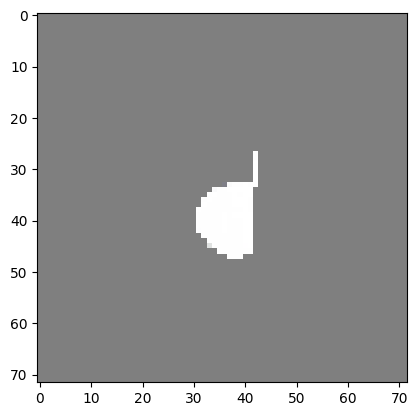

In [ ]:
img1 = root+'/testimages/patch5_0.png'
img2 = root+'/testimages/patch1_0.png'

test(img1, img2)

### Unzip the Yolo Model

In [ ]:
!unzip '{root}/final-yolov3.zip' -d '{root}/'

Archive:  drive/MyDrive/DEP/final-yolov3.zip
replace drive/MyDrive/DEP/final-yolov3/.dockerignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Helper Functions

In [ ]:
#0 0.838555 0.495993

# Since we have to process a video we cannot go directly, going with the previous procedure we have stored the captured
# frames of the videos into the dataset named list

# We have to use two models, so we have to go frame by frame only, we cannot use a batch
# The frames where the accuracy of the detected ball goes beyond 80% with the Yolo model, lets say the frame be some Yth frame
# Now we have to find the coordinates of the center of the bounding box of detected ball by the Yolo Model

# Since i have the center of the ball in the Yth frame
# Now go to the (Y+1)th frame and cut a patch of 72x72 with the same center of ball in the Yth frame

# Our Architecture take two consecutive frames as the input, so feed the (Y+1)th frame as both img1 & img2
# The architecture will process both the frames and return a binary segmented image of ball in the patch of the (y+1)th frame
# Now the binary segmented output will be representing the ball with 1's, so we have to find the center of the 1's in the output
# use the center to crop a patch in the (y+2)th frame and now give img1 = (y+1)th & img2 = (y+2)th as the input to the architecture
# also use the center to fill 1's in the original (y+1)th frame
# store all the frames in some final list
# convert the final list of processed frames to a final video, save the video and we are done


def cropImage(image, x1, y1):
    ''' Feed the frame with the center (x1, y1) to get the patch '''

    h, w, d = image.shape
    if (x1<1 and y1<1):
        x1 = x1*w
        y1 = y1*h

    x1 = int(x1)
    y1 = int(y1)

    flag = False
    half_side = 36

    # crop the image to get a patch of 70x70
    if(y1-half_side < 0):
        padding_rows = half_side-y1
        cropped_image = image[0:y1+half_side, x1-half_side:x1+half_side]
        cropped_image = np.pad(cropped_image, ((padding_rows, 0), (0, 0), (0, 0)), mode='constant', constant_values=0)
        flag = True

    if(x1-half_side < 0):
        padding_rows = half_side-x1
        cropped_image= image[y1-half_side:y1+half_side, 0:x1+half_side]
        cropped_image = np.pad(cropped_image, ((0, 0),(padding_rows, 0),(0, 0)), mode='constant', constant_values=0)
        flag = True

    if(y1+half_side >= h):
        padding_rows = h-y1
        cropped_image = image[y1-half_side:w, x1-half_side:x1+half_side]
        cropped_image= np.pad(cropped_image, ((0, padding_rows),(0, 0), (0, 0)), mode='constant', constant_values=0)
        flag = True

    if(x1+half_side >= w):
        padding_rows = w-x1
        cropped_image = image[y1-half_side:y1+half_side, x1-half_side:h]
        cropped_image= np.pad(cropped_image, ((0, 0),(0, padding_rows),(0, 0)), mode='constant', constant_values=0)
        flag = True

    if(flag == False): cropped_image = image[y1-half_side:y1+half_side, x1-half_side:x1+half_side]

    return cropped_image

In [ ]:
def find_big_coordinates(x_ball, y_ball, x_patch, y_patch, image):
    h, w, d = image.shape

    if x_patch<1 and y_patch<1:
        x_patch = x_patch*w
        y_patch = y_patch*h

    x_frame = (x_patch - 36) + x_ball
    y_frame = (y_patch - 36) + y_ball

    return x_frame, y_frame

In [ ]:
def add_circle(img, x, y):
    h, w, c = img.shape
    x, y = int(x*w), int(y*h)
    center = (x, y)
    radius = 5
    color = (255, 255, 255)
    thickness = -1
    print(center)
    print(type(img))
    print(img.shape)
    cv2.circle(img, center, radius, color, thickness)
    return img

In [ ]:
def save_video(final_image_list, output_folder):
    h, w, d = final_image_list[0].shape

    output_path = f'{output_folder}/out_video.mp4'
    fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    video = cv2.VideoWriter(output_path, fourcc, 15, (w, h))

    for j in final_image_list:
        video.write(j)

    print("Video saved!")
    cv2.destroyAllWindows()
    video.release()

### Merge Function

In [ ]:
path = root+'/final-yolov3'

def merge(dataset):
    # Here I am initializing some variables like x,y are intially 0,0 they will be updatd once yolo_accuracy>80% and flag is to switch between yolo
    # and architecture model ct will tell me whether its the first time or not that we'll have to use two same images in the architecture
    # prevImage will store the 1st image that will go to the connection function and yolostart is when we have first image we dont know the accuracy we'll just apply yolo

    final_img_list = []
    flag = True         # True for YoloModel and False for PatchModel
    patchflag = True    # True for first time and False from second time
    x_yolo, y_yolo = 0., 0.     # center of ball given by yolo model in the complete frame
    x_ball, y_ball, = 0., 0.    # center of ball given by patch model in the patch of a frame
    x_patch, y_patch = 0., 0.   # center of the patch cropped
    x_frame, y_frame = 0., 0.   # center of ball in the complete frame
    prev_img = 0
    accuracy_yolo=0

    ball_coords = []

    for i in range(len(dataset)-1):
        img_path = dataset[i]

        # YOLO model
        if flag == True:
            print("yolo")
            !python {path}/detect.py --weights {path}/runs/train/exp7/weights/best.pt --source {img_path} --outputs coordinates/coord
            print("Yolo detection done")

            with open("coordinates/coord.pkl", "rb") as file:
                coords = pickle.load(file)

            print("found coord")
            coords = coords[-1]
            accuracy_yolo = coords[1]*100
            x_yolo = (coords[2][0] + coords[2][2]) / 2
            y_yolo = (coords[2][1] + coords[2][3]) / 2
            print("coord: ", coords)
            print(accuracy_yolo, x_yolo, y_yolo)

            if accuracy_yolo >= 80:
                print("accuracy greater than 80")
                flag = False # to switch to the different architecture

            ball_coords.append( [x_yolo, y_yolo] )

        # Patch Model
        else:
            frame = cv2.imread(img_path)
            frame = np.array(frame)
            frame = frame.astype(np.float32)

            if patchflag == True:  # same images first time
                print("Virgin PatchModel")
                frame2 = frame
                cropped_img1 = cropImage(frame, x_yolo, y_yolo)
                cropped_img2 = cropped_img1
                print(cropped_img1.shape)

                x_patch, y_patch = x_yolo, y_yolo
                prev_img = cropped_img2
                patchflag = False

            else:   # different frames
                print("Playboy PatchModel")
                img_path2 = dataset[i+1]
                frame2 = cv2.imread(img_path1)
                frame2 = np.array(frame2)
                frame2 = frame2.astype(np.float32)

                cropped_img1 = prev_img
                cropped_img2 = cropImage(frame2, x_patch, y_patch)
                prev_img = cropped_img2


            print("Cropping Done")
            cropped_img1 = torch.tensor(cropped_img1)
            cropped_img2 = torch.tensor(cropped_img2)
            cropped_img1 = torch.unsqueeze(cropped_img1,0)
            cropped_img2 = torch.unsqueeze(cropped_img2,0)

            cropped_img1 = cropped_img1.permute(0, 3, 2, 1)
            cropped_img2 = cropped_img2.permute(0, 3, 2, 1)

            cropped_img1 = to_device(device, cropped_img1)
            cropped_img2 = to_device(device, cropped_img2)

            print(cropped_img1.shape)
            print(cropped_img1.device)

            print("Inserting cropped images to PatchModel")
            res = PatchModel(cropped_img1, cropped_img2)
            res = torch.sigmoid(res)
            print(res)
            break

            print("Got PatchModel Output")
            x_ball, y_ball = find_patch_centroid(res)
            print("Found Patch Coordinates")
            x_frame, y_frame = find_big_coordinates(x_ball, y_ball, x_patch, y_patch, frame2)
            print("Found Big Coordinates")
            print("centers: ", x_ball, y_ball, x_patch, y_patch, x_frame, y_frame, x_yolo, y_yolo)


            ball_coords.append( [x_frame, y_frame] )
            x_patch, y_patch = x_frame, y_frame


    # Appending final ball coordinates
    with open("final_coords.pkl", "wb") as file:
        pickle.load(ball_coords, file)

    # returning the final_img_list
    return ball_coords

### Dataset Preparation for Testing

In [ ]:
# Program To Read video and Extract Frames
def FrameCapture(path):
    img_folder = "images"
    if not os.path.exists(img_folder):
        os.makedirs(img_folder)

    vidObj = cv2.VideoCapture(path)
    success = 1
    count = 0
    cnt = True

    while success:
        success, image = vidObj.read()
        if cnt == True:
            h, w, c = image.shape
            cnt = False

        if image is None: continue
        if(image.shape == (h, w, c)):
            cv2.imwrite("images/frame%d.jpg" % count, image)
            count += 1

In [ ]:
data_folder = root+"/test_videos"
videos_list = [v for v in os.listdir(data_folder) if v.lower().endswith(('.mp4'))]
print(videos_list)

# Read the videos and save the frame to images folder
for video_name in videos_list:
    video_path = os.path.join(data_folder, video_name)
    FrameCapture(video_path)

dataset = ['images/'+p for p in os.listdir('images')]

print(len(dataset))
print(dataset[0])

['unseen_output_video.mp4']
15
images/frame1.jpg


### Run Testing

In [ ]:
ball_coords = merge(dataset)

yolo
detect: outputs=coordinates/coord, weights=['drive/MyDrive/DEP/final-yolov3/runs/train/exp7/weights/best.pt'], source=images/frame1.jpg, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=True, save_txt=True, save_conf=True, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=True, update=True, project=drive/.shortcut-targets-by-id/15pTYB9TpP62KZRTjPT5VylHGPbYvlLJk/DEP/final-yolov3/runs/detect, name=new, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
Expected end or semicolon (after name and no valid version specifier)
    alabaster=0.7.12=py37_0
             ^
YOLOR 🚀 v9.6.0-22-g0bbd055 torch 2.2.1+cu121 CUDA:0 (Tesla T4, 15102.0625MB)

Fusing layers... 
Model Summary: 333 layers, 61949149 parameters, 0 gradients
image 1/1 /content/images/frame1.jpg: 640x640 1 sports ball, Done. (0.191s)
dataset mode:  image
save_path runs/detect/newdetections/frame1.jpg
Saving the out

TypeError: load() takes exactly 1 positional argument (2 given)

In [ ]:
# Add white circle to frames in place of ball
final_img_list = [add_circle(dataset[i], ball_coords[i][0], ball_coords[i][1]) for i in range(len(ball_coords))]
%rm -r "images"

# Convert frames to Video and save to output_folder
output_folder = "output"
save_video(final_img_list, output_folder)

### Test Patch

In [ ]:
def test_patch(dataset):
    patchflag = True
    x_yolo, y_yolo = 0., 0.     # center of ball given by yolo model in the complete frame
    x_ball, y_ball, = 0., 0.    # center of ball given by patch model in the patch of a frame
    x_patch, y_patch = 0., 0.   # center of the patch cropped
    x_frame, y_frame = 0., 0.   # center of ball in the complete frame

    for i in range(len(dataset)-1):
        img_path = dataset[i]
        frame = cv2.imread(img_path)
        frame = np.array(frame)
        frame = frame.astype(np.float32)

        if patchflag == True:  # same images first time
            print("Virgin PatchModel")
            frame2 = frame
            cropped_img1 = cropImage(frame, x_yolo, y_yolo)
            cropped_img2 = cropped_img1
            print(cropped_img1.shape)

            x_patch, y_patch = x_yolo, y_yolo
            prev_img = cropped_img2
            patchflag = False

        else:   # different frames
            print("Playboy PatchModel")
            img_path2 = dataset[i+1]
            frame2 = cv2.imread(img_path2)
            frame2 = np.array(frame2)
            frame2 = frame2.astype(np.float32)

            cropped_img1 = prev_img
            cropped_img2 = cropImage(frame2, x_patch, y_patch)
            prev_img = cropped_img2


        print("Cropping Done")
        cropped_img1 = torch.tensor(cropped_img1)
        cropped_img2 = torch.tensor(cropped_img2)
        cropped_img1 = torch.unsqueeze(cropped_img1,0)
        cropped_img2 = torch.unsqueeze(cropped_img2,0)

        cropped_img1 = cropped_img1.permute(0, 3, 2, 1)
        cropped_img2 = cropped_img2.permute(0, 3, 2, 1)

        cropped_img1 = to_device(device, cropped_img1)
        cropped_img2 = to_device(device, cropped_img2)

        print(cropped_img1.shape)
        print(cropped_img1.device)

        print("Inserting cropped images to PatchModel")
        res = PatchModel(cropped_img1, cropped_img2)
        res = torch.sigmoid(res)

        print("Got PatchModel Output")
        x_ball, y_ball = find_patch_centroid(res)
        print("Found Patch Coordinates")
        x_frame, y_frame = find_big_coordinates(x_ball, y_ball, x_patch, y_patch, frame2)
        print("Found Big Coordinates")
        print("centers: ", x_ball, y_ball, x_patch, y_patch, x_frame, y_frame, x_yolo, y_yolo)
